# 0. Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)
plt.rcParams["figure.autolayout"] = True
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sc
from statsmodels.stats.stattools import durbin_watson
import yfinance as yf
from sqlite3 import connect as sqlconnect
# import plotly for interactive plots
import chart_studio.plotly as py
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"
init_notebook_mode(connected=True)


# 1. Data

## 1.1 Importing 

In [2]:
tickers = ['GOOG']
df = yf.download(tickers=tickers,  group_by=tickers)

[*********************100%***********************]  1 of 1 completed


In [2]:
def save_df(df:pd.DataFrame, table_name:str='stock_price') -> None:
    '''Saves the dataframe df, assuming is a timeseries in an sqlite3 database in the root folder.
    '''
    with (conn:= sqlconnect(f'{table_name}.db')):
        df.reset_index().to_sql(table_name, conn, if_exists='replace', index=False) # writes to file
    conn.close()

In [4]:
save_df(df=df)

In [3]:
def load_df(table_name:str='stock_price') -> pd.DataFrame:
    '''Loads the dataframe df, saved in stock_price.db. Assumes that the dataframe is in time series form.
    '''
    with (conn := sqlconnect(f'{table_name}.db')):
        df = pd.read_sql(f'select * from {table_name}', conn, index_col='Date', parse_dates=['Date'])
    conn.close()
    return df

In [4]:
df = load_df()

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2022-10-13,95.930000,100.529999,95.269997,99.709999,99.709999,32812200
2022-10-14,100.625000,101.290001,97.029999,97.180000,97.180000,22612900
2022-10-17,99.519997,101.769997,99.510002,100.779999,100.779999,23311600


General info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4575 entries, 2004-08-19 to 2022-10-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4575 non-null   float64
 1   High       4575 non-null   float64
 2   Low        4575 non-null   float64
 3   Close      4575 non-null   float64
 4   Adj Close  4575 non-null   float64
 5   Volume     4575 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 250.2 KB


No NaN or null values

In [3]:
df.isnull().values.any()
df.isna().values.any()

False

False

Max/Min dates

In [10]:
df.index.min()

Timestamp('2004-08-19 00:00:00')

In [11]:
df.index.max()

Timestamp('2022-10-19 00:00:00')

Total period

In [12]:
df.index.max()-df.index.min()

Timedelta('6635 days 00:00:00')

## 1.2 Exploratory Data Analysis

In [13]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4.575000e+03
mean,37.001034,37.377101,36.625506,37.006944,37.006944,1.246551e+08
std,34.909405,35.286594,34.544531,34.916540,34.916540,1.540017e+08
min,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,12.515215,12.661417,12.375738,12.524306,12.524306,3.019400e+07
50%,22.450102,22.572144,22.306889,22.493439,22.493439,6.948600e+07
75%,52.864750,53.519501,52.316502,52.848251,52.848251,1.563137e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


Let's probe the OHLC correlation

In [14]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999907,0.999894,0.999784,0.999784,-0.461084
High,0.999907,1.000000,0.999868,0.999894,0.999894,-0.460034
Low,0.999894,0.999868,1.000000,0.999905,0.999905,-0.462584
Close,0.999784,0.999894,0.999905,1.000000,1.000000,-0.461460
Adj Close,0.999784,0.999894,0.999905,1.000000,1.000000,-0.461460
Volume,-0.461084,-0.460034,-0.462584,-0.461460,-0.461460,1.000000


Pretty much all OHLC is almost perfectly correlated. Which means we could use Open prices as the independent variable X and try to predict the Close price y. 
- This is obviously not the best choice since in a real scenario we would be able to predict the Close price once we have the latest Open price.
- Other more efficient ways are using technical indicators as X. We will persue one such case later.

<AxesSubplot:xlabel='Open', ylabel='Close'>

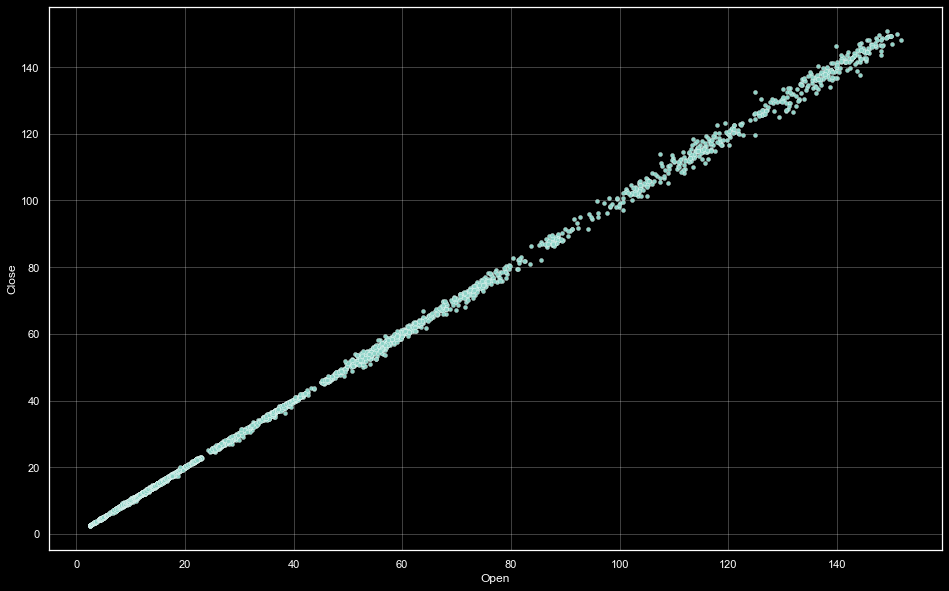

In [15]:
sns.scatterplot(x=df['Open'], y=df['Close'])

Open and Close prices are indeed linearly related.

# 2. X as Open Price

## 2.1 Preparing Data

The Close price is chosen as the dependent variable y

In [4]:
y = df.loc[:, df.columns.get_level_values(0) == 'Close'] #this is to ensure a 2-D array later on, as opposed to just df['Close'] which results in 1-D array
y.values

array([[  2.49913311],
       [  2.69763899],
       [  2.724787  ],
       ...,
       [101.38999939],
       [100.29000092],
       [100.52999878]])

The Open price is chosen as the independent variable X

In [5]:
X = df.loc[:, df.columns.get_level_values(0) == 'Open']

We separate the data into train and test parts with 30% being the test part.

In [33]:
X_train, X_test, y_train, y_test = [x.sort_index() for x in train_test_split(X, y, test_size=0.3, random_state=101)]

Text(0.5, 1.0, 'Train Close and Open Prices')

<AxesSubplot:title={'center':'Train Close and Open Prices'}, xlabel='Open', ylabel='Close'>

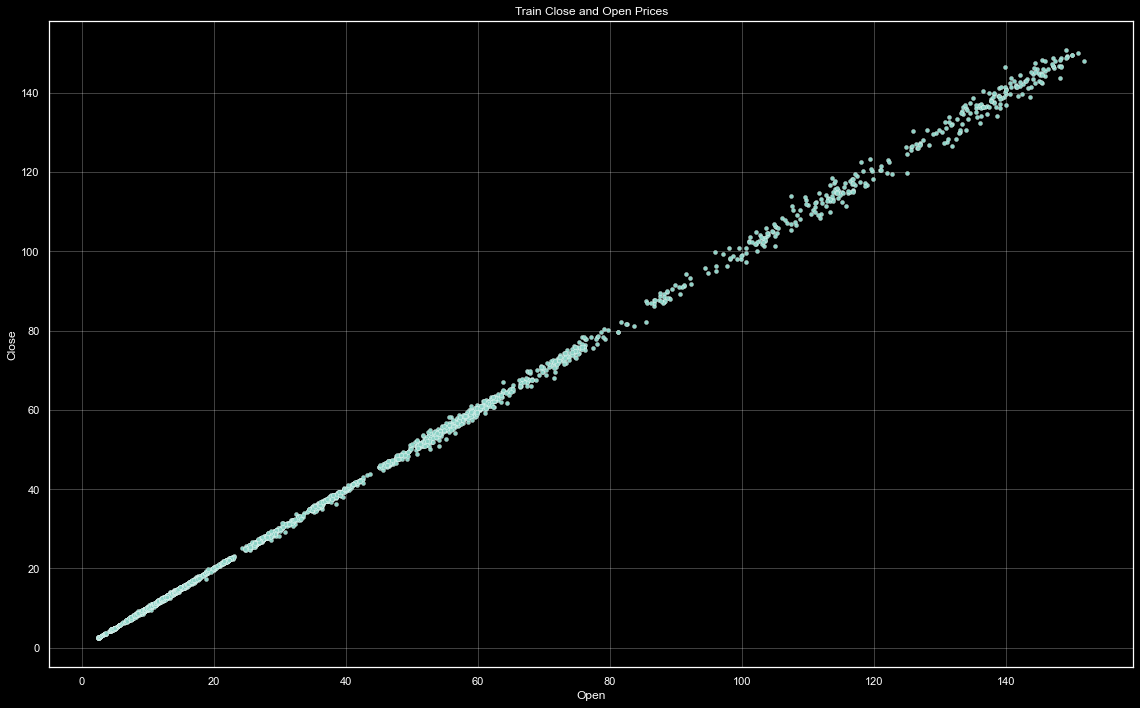

In [34]:
plt.title('Train Close and Open Prices')
sns.scatterplot(x=X_train['Open'], y=y_train['Close'], edgecolor='w')

Text(0.5, 1.0, 'Test Close and Open Prices')

<AxesSubplot:title={'center':'Test Close and Open Prices'}, xlabel='Open', ylabel='Close'>

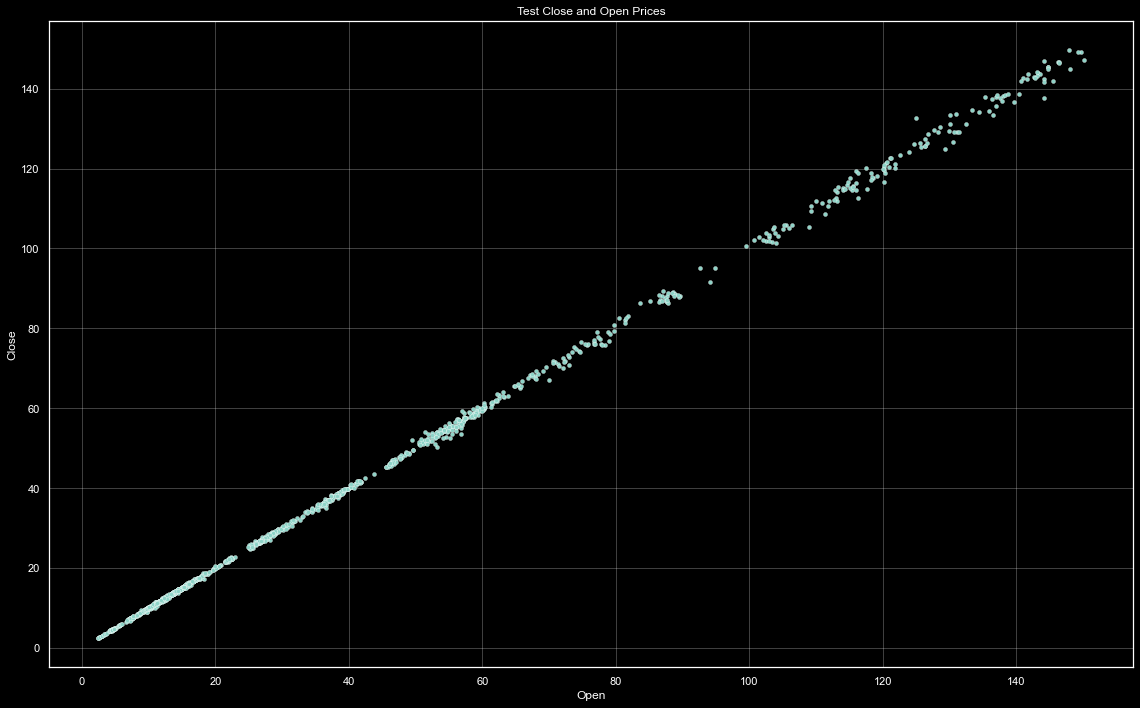

In [35]:
plt.title('Test Close and Open Prices')
sns.scatterplot(x=X_test['Open'], y=y_test['Close'], edgecolor='w')

The linearity is still consistent and evident after training and spliting the dataset.

## 2.2 Model

### 2.2.1 Theory

The model in our case will be Simple Linear Regression since
- Only one dependent variable has been chosen y (Close prices). This is also what we are trying to predict.
- Only one independent variable has been chose X (Open prices).
- There is an obvious linear relation between the Close and Open prices.

The formula for the straight line is:
$$ y = \lambda X + b $$

where

- $ y $ dependent variable to be predicted
- $ b $ is the y-intercept
- $ \lambda $ is the slope
- $ X $ is the independent variable

The plan is to find $ \lambda $ and $ b $ such that we realize the best fitted line through the datapoints. The term best fitted will be achieved, in general, by minimizing the sum of the squared errors from the test points and the actual predicted points.

### 2.2.2 Working with the model

In [36]:
model = LinearRegression(copy_X=True)

In [37]:
model.fit(X_train, y_train)

LinearRegression()

In [38]:
mini_summary = f'''
Model: {model}.
There were n = {model.n_features_in_} features, with names: {model.feature_names_in_}.
The Slope calculated is {model.coef_.flatten()}.
The Intercept calculated is {model.intercept_}.
'''
print(mini_summary)


Model: LinearRegression().
There were n = 1 features, with names: ['Open'].
The Slope calculated is [0.99993377].
The Intercept calculated is [0.01038758].



Interpretation

- The slope coefficient translates a 1 unit increase of Open price into 1.0005142 units of increase in Close price. This high value was kind of expected to due the almost perfect correlation of Open and Close prices.
- The intercept coefficient has no significance in this case. One may interpret is as the Close price when the Open price was 0. However there is no 0 Open price yet.

In [39]:
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index).sort_index()
y_pred

,Close
Date,
2004-08-19,2.500887
2004-08-25,2.624416
2004-08-27,2.702617
2004-09-01,2.568130
2004-09-02,2.480714
...,...
2022-09-19,102.543598
2022-09-20,102.883572
2022-09-22,99.453798


We define a utility plot function in order to be able to compare our results

In [40]:
# fig = plot_results(y_train, y_test, y_pred)
# fig
# fig.write_html('test.html', include_plotlyjs='cdn')
# print(fig.to_html())

We see that there is already a pretty good fit in most places and in others at least the trend is correctly produced in the most part.

In [41]:
# One can reproduce with the usual manner the above plot with seaborn
# sns.lineplot(x=y_pred.index, y=y_pred['Close'], label='Predicted Close')
# sns.lineplot(x=y_pred.index, y=y_test['Close'], label='Actual Close')

## 2.3 Model Evaluation

### 2.3.1 Error Evaluation metric

For the purposes of this project only the Root Mean Squared Error(RMSE) will be needed.

RMSE is the square root of the mean of the squared errors defined as:
$$ RMSE = \sqrt{\dfrac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2} $$

In [42]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
RMSE

0.7283043331410478

which is negligible 

In [71]:
RMSE/df[['Open', 'Close']].describe().loc['mean']

Open     1.363852
Close    1.363634
Name: mean, dtype: float64

compared to the mean in

In [19]:
df[['Open', 'Close']].describe()

,Open,Close
count,4575.000000,4575.000000
mean,37.001034,37.006944
std,34.909405,34.916540
min,2.470490,2.490913
25%,12.515215,12.524306
50%,22.450102,22.493439
75%,52.864750,52.848251
max,151.863495,150.709000


### 2.3.2 Accuracy Evaluation metric

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

The range of values of the Coefficient of determination is $ 0 \leq R^2 \leq 1 $.

RSS is defined as $$ R^2 =  1 - \dfrac{RSS}{TSS} $$

where:

- Residual Sum of Squares:
$$ RSS = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$

- Total Sum of Squares:
$$ TSS = \sum_{i=1}^{N} (y_i - \bar{y}_i)^2 $$

- $\hat y_i$ is the predicted value of the i-th sample
- $y_i$ is the corresponding true value for i-th sample

In [72]:
r2_score(y_test, y_pred)

-1.0310785519424188

which means that all variance of y(Close Prices) is explained by X(Open Prices).

## 2.3.3 Residual Analysis

The residuals are defined as $$ \epsilon = y_i - \hat y_i $$ where $y_i$ is the actual value and $\hat y_i$ is the predicted value

In Linear Regression the assumptions about residuals are:
1. Residuals should be independent of each other.
   - i.e they should not form any patterns in a plot, otherwise there is nonlinearity
2. Residuals should have constant variance.
   - i.e they should not increase or decrease abruptly.
3. The expected value or mean of the residuals should be zero. $ \bar \epsilon = 0 $
4. Residuals should follow a normal distribution.
   - In reality they have to be as close to following a normal distribution as possible.
   - Skewness is a measure of symmetry. Skew(normal)=0
   - Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. Kurtosis(normal)=0

Notes on autocorrelation:

1. Autocorrelation measures the relationship between a variable's current value and its past values.
2. An autocorrelation of 
   - +1 represents a perfect positive correlation => an increase seen in one time series leads to a proportionate increase in the other time series
   - -1 represents a perfect negative correlation => an increase seen in one time series results in a proportionate decrease in the other time series
3. Autocorrelation measures linear relationships. Even if the autocorrelation is minuscule, there can still be a nonlinear relationship between a time series and a lagged version of itself.

Tests for autocorrelation:
1. Pearson correlation between the Series and its shifted self. $ -1 \leq TEST \leq 1 $
   - Value = 1 max positive correlation
   - Value = -1 max negative correlation
2. The Durbin-Watson test of residuals $ 0 \leq TEST \leq 4 $
   -  Values ~ 0 indicate a greater degree of positive correlation, 
   -  Values ~ 4 indicate a greater degree of negative autocorrelation, 
   -  Values ~ 2 suggest less to none autocorrelation.

# 3. Package the analysis to a class

In [10]:
def plot_results(y_train:pd.DataFrame, y_test:pd.DataFrame, y_pred:pd.DataFrame) -> go.Figure:
    '''Plots interactively the overall data y, the test data y_test and the predicted data y_pred.
        Params
        y: Total data.
        y_test: Portion of the total data y to be used for testing.
        y_pred: Predicted data.
    '''
    fig = go.Figure()
    for df, name in [(y_train,'Train'), (y_test, 'Test'), (y_pred, 'Predicted')]:
        df = df.sort_index()
        fig.add_trace(go.Scatter(x=df.index, y=df.loc[:,'Close'], name=name))
    update_options = {
            'title':'Train, Test and Predicted Close Prices',
            'legend_title_text': 'Close Prices',
            'font': {
                'size':16,
                'color':"#7f7f7f"
            },
            'xaxis_title': y.index.name,
            'yaxis_title': 'Close'
        }
    fig.update_layout(**update_options)
    return fig
class Model:
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, testsize:float=0.3, random_state:int=101, shuffle=False, model=LinearRegression) -> None:
        self.X = X
        self.y = y
        self.testsize = testsize
        self.random_state = random_state
        self.shuffle = shuffle
        self.model = model()
        self.__train_test_split()
        self.__util_df()
        self.__model_fit()
        self.y_pred = pd.DataFrame(self.model.predict(self.X_test), columns=self.y_test.columns, index=self.y_test.index).sort_index()
        self.residuals = self.y_test - self.y_pred
        self.summary_result()
        print(self.summary_residuals())
        self.plot_result().show()
        
    
    def __train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = [x.sort_index() for x in train_test_split(self.X, self.y, test_size=self.testsize, shuffle=self.shuffle, random_state=self.random_state)]

    def __util_df(self) -> None:
        self.df = pd.concat([self.y, self.X], axis=1)
        self.df_train = pd.concat([self.y_train, self.X_train], axis=1)
        self.df_test = pd.concat([self.y_test, self.X_test], axis=1)
    
    def plot_actual_data(self) -> None:
        g = sns.pairplot(self.df, corner=True, diag_kind="kde", height=4, aspect=1.5)
        g.fig.suptitle("Actual Data", y=1.04)
        return g

    def plot_train_data(self) -> None:
        g = sns.pairplot(self.df_train, corner=True, diag_kind="kde", height=4, aspect=1.5)
        g.fig.suptitle("Train Data", y=1.04)
        return g

    def plot_test_data(self) -> None:
        g = sns.pairplot(self.df_test, corner=True, diag_kind="kde", height=4, aspect=1.5)
        g.fig.suptitle("Test Data", y=1.04)
        return g

    def __model_fit(self) -> None:
        self.model.fit(self.X_train, self.y_train)

    def summary_result(self) -> None:
        summary = f'''
Model: {self.model}.
There were n = {self.model.n_features_in_} features, with names: {self.model.feature_names_in_}.
The Slope calculated is {np.round(self.model.coef_.flatten(),2)}.
The Intercept calculated is {np.round(self.model.intercept_,2)}.
The Root Mean Square Error is: {np.round(np.sqrt(mean_squared_error(self.y_test, self.y_pred)),2)}
The Coefficient of Determination R^2 is: {np.round(r2_score(self.y_test, self.y_pred),2)}
'''
        print(summary)

    def summary_residuals(self) -> pd.DataFrame:
        return  pd.concat(
            [
            self.residuals.describe(),
            self.residuals.kurtosis().to_frame().T.rename({0:'kurtosis'}),
            self.residuals.skew().to_frame().T.rename({0:'skew'}),
            self.residuals.var().to_frame().T.rename({0:'var'}),
            self.residuals.agg(durbin_watson).to_frame().T.rename({0:'D.Watson'})
            ]
            ).rename(columns={'Close':'Residuals'})
    
    def plot_result(self) -> go.Figure:
        return plot_results(self.y_train, self.y_test, self.y_pred)

    def plot_residuals(self) -> plt.Figure:
        fig, axes = plt.subplots(3, 2, figsize=(22, 10))
        # residuals vs y_pred scatterplot
        sns.scatterplot(ax=axes[0,0], x=self.y_pred['Close'], y=self.residuals['Close'],  label='Residuals')
        axes[0,0].hlines(xmin=self.y_pred['Close'].min(), xmax=self.y_pred['Close'].max(), y=0, color='red', label='Normality')
        axes[0,0].set_ylabel('Residuals')
        axes[0,0].set_xlabel('y_pred')
        axes[0,0].set_title('Residuals VS Predicted data')
        # residuals vs y_test scatterplot
        sns.scatterplot(ax=axes[0,1], x=self.y_test['Close'], y=self.residuals['Close'], label='Residuals')
        axes[0,1].hlines(xmin=self.y_test['Close'].min(), xmax=self.y_test['Close'].max(), y=0, color='red', label='Normality')
        axes[0,1].set_ylabel('Residuals')
        axes[0,1].set_xlabel('y_test')
        axes[0,1].set_title('Residuals VS Test data')
        # residuals histplot
        sns.histplot(ax=axes[1,0], data=self.residuals['Close'], kde=True)
        axes[1,0].set_xlabel('Residuals')
        axes[1,0].set_title('Histogram for Residuals')
        # residuals probplot
        sc.stats.probplot(self.residuals['Close'], plot=axes[1,1])
        # autocorrelation plots residuals vs ordered X
        sns.scatterplot(x=self.residuals.index, y=self.residuals['Close'], ax=axes[2,0])
        axes[2,0].hlines(xmin=self.residuals.index.min(), xmax=self.residuals.index.max(), y=0, color='red', label='Normality')
        axes[2,0].set_ylabel('Residuals')
        axes[2,0].set_title('Residuals VS Time')
        # autocorrelation vs lag
        pd.plotting.autocorrelation_plot(self.residuals['Close'], ax=axes[2,1])
        axes[2,1].hlines(xmin=-0.05*len(self.residuals), xmax=1.05*len(self.residuals), y=0, color='red', label='Normality')



Model = Model(X, y)
# Model.plot_result()


Model: LinearRegression().
There were n = 1 features, with names: ['Open'].
The Slope calculated is [1.].
The Intercept calculated is [-0.].
The Root Mean Square Error is: 1.27
The Coefficient of Determination R^2 is: 1.0

            Residuals
count     1373.000000
mean         0.057346
std          1.270201
min         -6.486731
25%         -0.477628
50%          0.074509
75%          0.668043
max          7.709013
kurtosis     3.997693
skew        -0.125120
var          1.613412
D.Watson     2.145040


# 3. X as SMA

## 3.1 SMAs

In [170]:
df = load_df()

Simple Moving Averages (SMA)

A simple moving average tells us the unweighted mean of the previous K data points. The more the value of K the more smooth is the curve, but increasing K decreases accuracy. 

<AxesSubplot:xlabel='Date'>

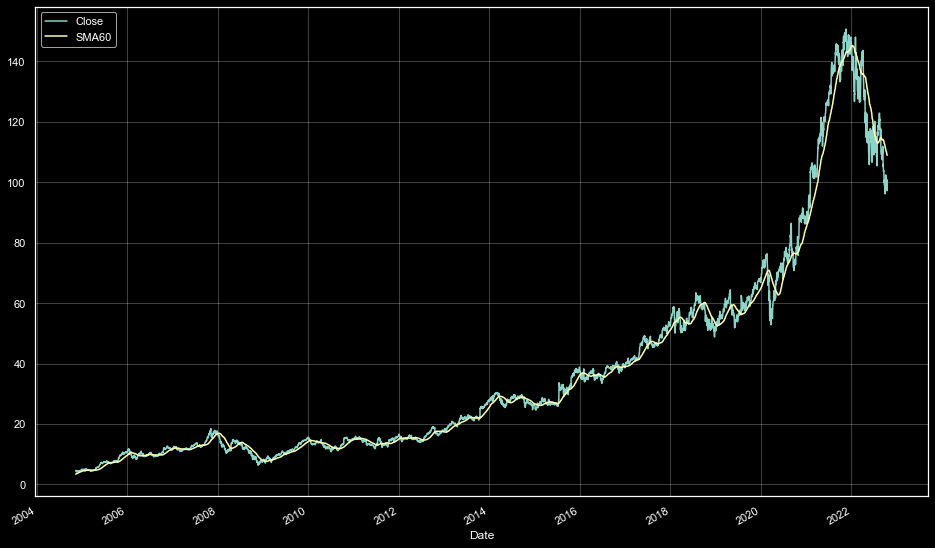

In [136]:
windows = [3, 15, 30, 60]
for window in windows:
    df[f'SMA{window}'] = df['Close'].rolling(window=window).mean()
df = df.dropna()
df[['Close', 'SMA60']].plot()

## 3.2 Preparing data

The independent variable is

In [ ]:
mask = np.isin(df.columns.get_level_values(0), [f'SMA{x}' for x in windows])
X = df.loc[:, mask]
X.shape

(4514, 4)

The dependent variable is the same

In [ ]:
y = df.loc[:, df.columns.get_level_values(0) == 'Close']
y.shape

(4514, 1)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [153]:
df = pd.concat([y, X], axis=1)
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

Let's visualize the original data in question

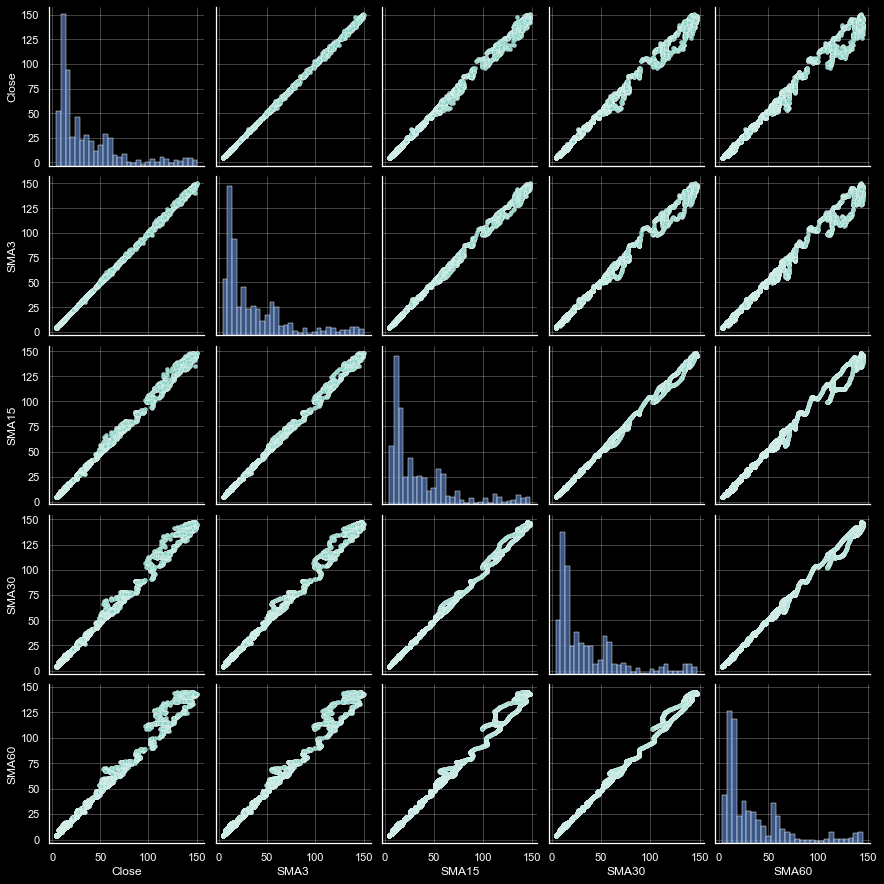

In [158]:
sns.pairplot(data=df)

Let's visualize the train part of df

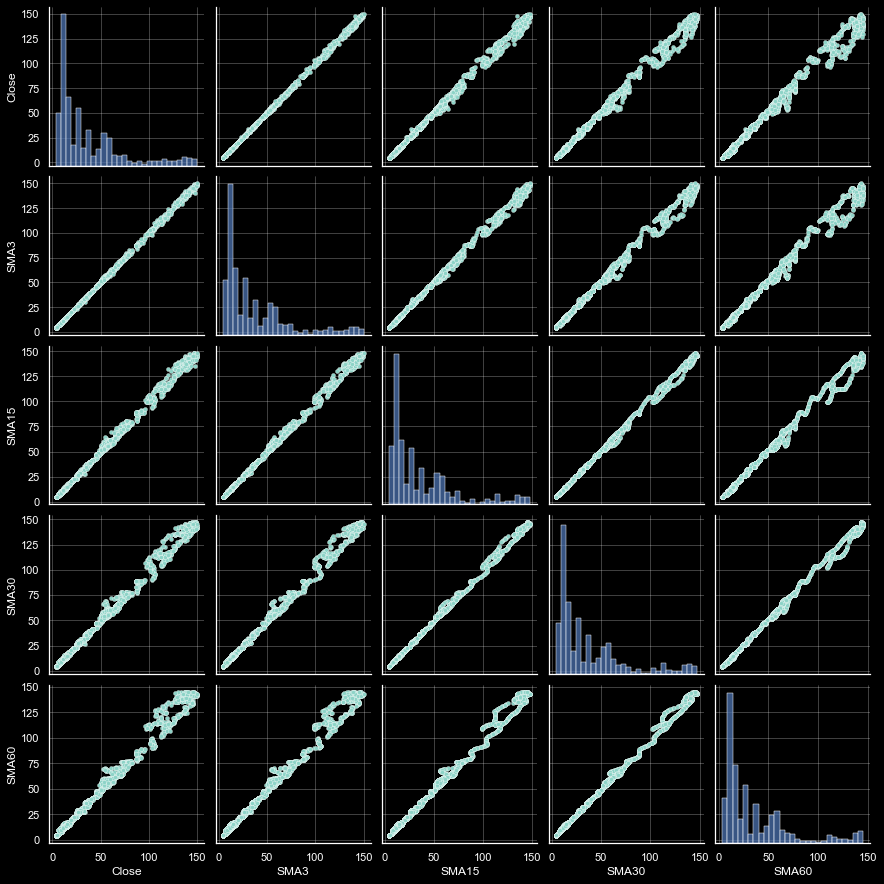

In [154]:
sns.pairplot(data=df_train)

Let's visualize the test part of df

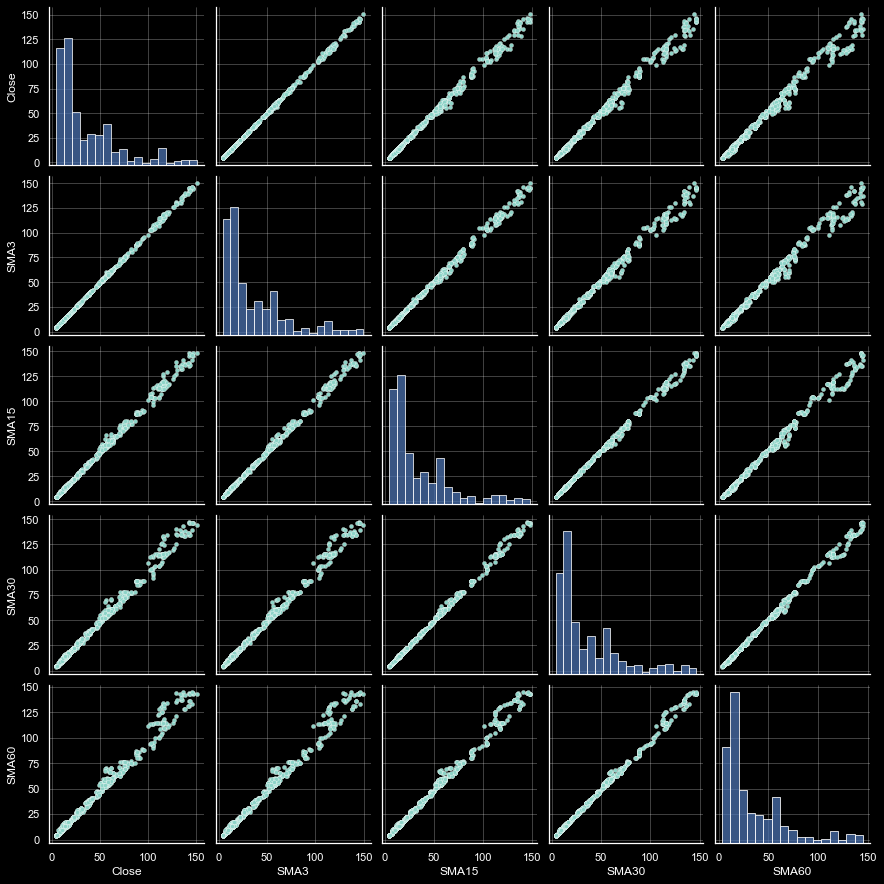

In [155]:
sns.pairplot(data=df_test)

We see that the train and test parts keep the same overall shapes as df. The difference is that they are less opaque which is reasonable since they are reduced in rows.

## 3.3 Model

In [160]:
model = LinearRegression(copy_X=True)

In [161]:
model.fit(X_train, y_train)

LinearRegression()

In [162]:
mini_summary = f'''
There were n = {model.n_features_in_} features, with names: {model.feature_names_in_} in the model: {model}.
The Slope calculated is {model.coef_.flatten()}.
The Intercept calculated is {model.intercept_}.
'''
print(mini_summary)


There were n = 4 features, with names: ['SMA3' 'SMA15' 'SMA30' 'SMA60'] in the model: LinearRegression().
The Slope calculated is [ 1.11993588e+00 -1.62090660e-01  4.08546136e-02  1.05592828e-03].
The Intercept calculated is [0.01927964].



It is obvious that as we increase the window the contribution the higher window SMAs contribute less to the affine equation of the regression.

This is also evident from the fact that the moving averages become smoother and less accurate as the window increases.

In [163]:
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred

,Close
Date,
2017-07-18,48.117233
2007-02-08,11.702447
2008-03-20,10.872824
2005-04-25,5.407811
2018-02-27,56.835768
...,...
2022-08-22,117.702030
2019-07-16,57.646595
2011-09-20,13.664850


## 3.4 Model Evaluation

In [169]:
mini_summary = f'''The Root Mean Square Error is: {np.sqrt(mean_squared_error(y_test,y_pred))}
The Correlation Coefficient $R^2$ is: {r2_score(y_test, y_pred)}
'''
print(mini_summary)

The Root Mean Square Error is: 0.6285628904156488
The Correlation Coefficient $R^2$ is: 0.9996404022028367



<AxesSubplot:xlabel='Close', ylabel='Close'>

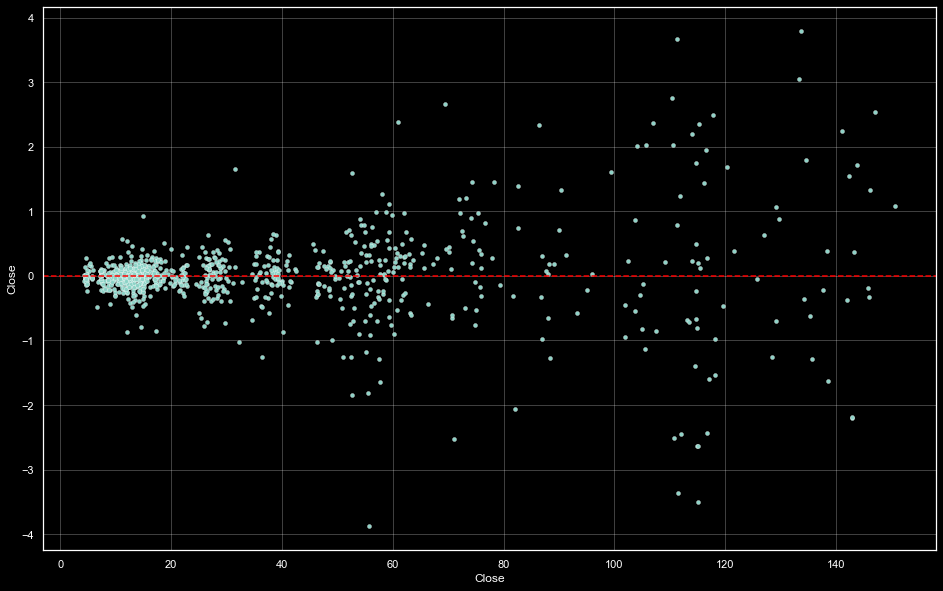

In [166]:
test_residuals = (y_test - y_pred)
sns.scatterplot(x=y_test['Close'], y=test_residuals['Close'])
plt.axhline(y=0, color='red', ls='--', label='Normality')

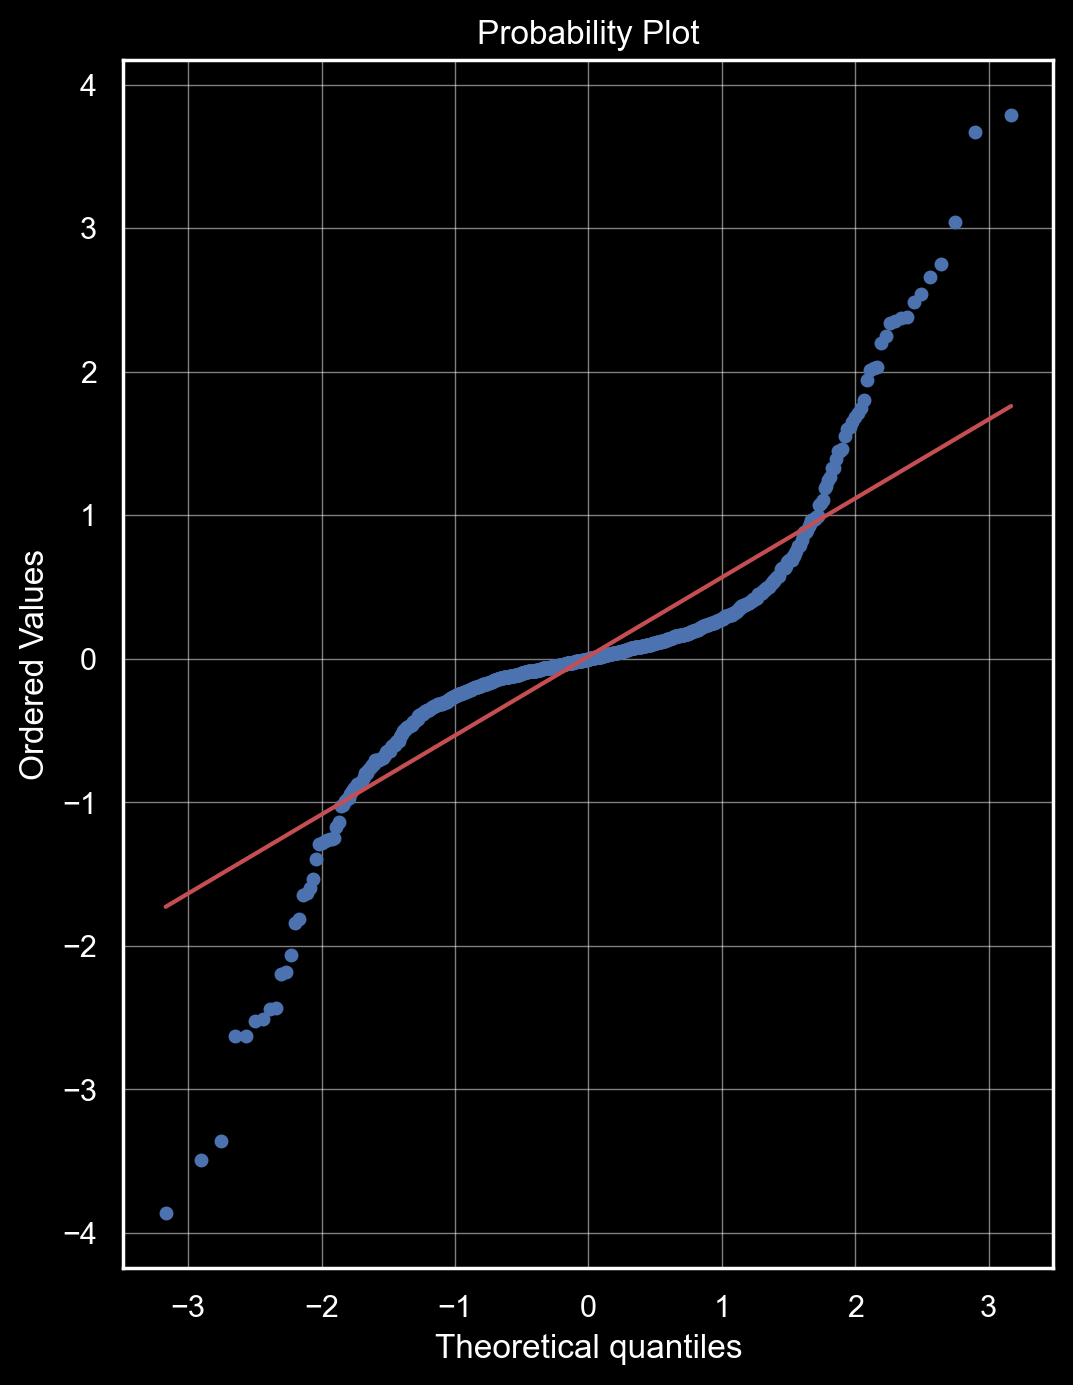

In [167]:
fig, ax = plt.subplots(figsize=(6,8),dpi=200)
_ = sc.stats.probplot(test_residuals['Close'], plot=ax)

# 4. X as MA

## 4.1 SMAs

In [ ]:
df = load_df()

<AxesSubplot:xlabel='Date', ylabel='Moving Averages'>

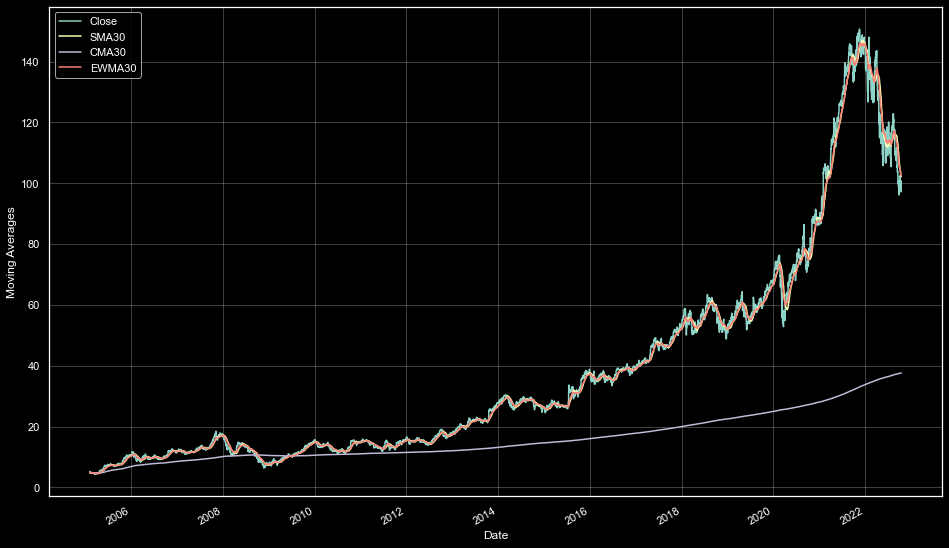

In [174]:
# sma
df['SMA30'] = df['Close'].rolling(30).mean()
# cumulative mean
df['CMA30'] = df['Close'].expanding().mean()
# exp moving avg
df['EWMA30'] = df['Close'].ewm(span=30).mean()
df = df.dropna()
df[['Close', 'SMA30', 'CMA30', 'EWMA30']].plot(ylabel='Moving Averages')

In [175]:
df.shape

(4457, 9)

## 4.2 Preparing Data

In [176]:
mask = np.isin(df.columns.get_level_values(0), ['SMA30', 'CMA30', 'EWMA30'])
X = df.loc[:, mask]
X.shape

(4457, 3)

The dependent variable is the same

In [177]:
y = df.loc[:, df.columns.get_level_values(0) == 'Close']
y.shape

(4457, 1)

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [179]:
df = pd.concat([y, X], axis=1)
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

Let's visualize the original data in question

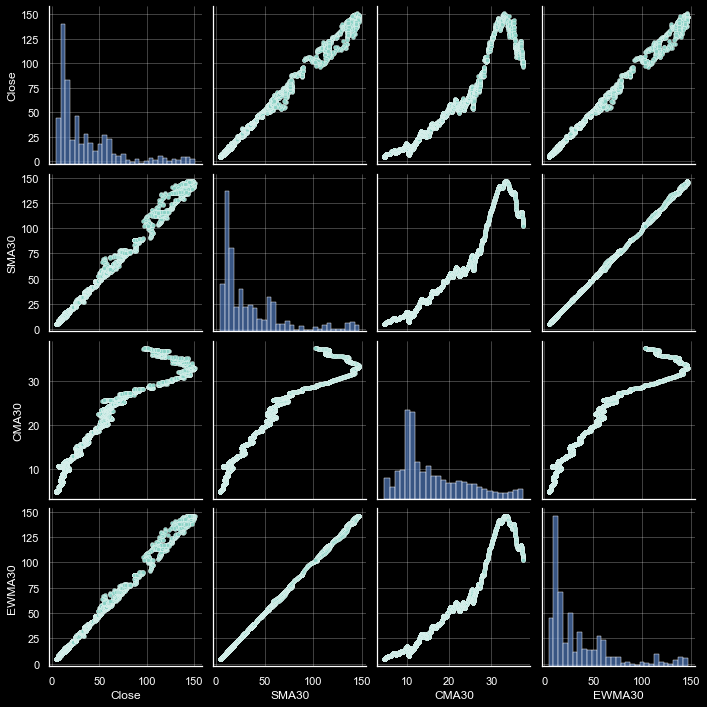

In [180]:
sns.pairplot(data=df)

Let's visualize the train part of df

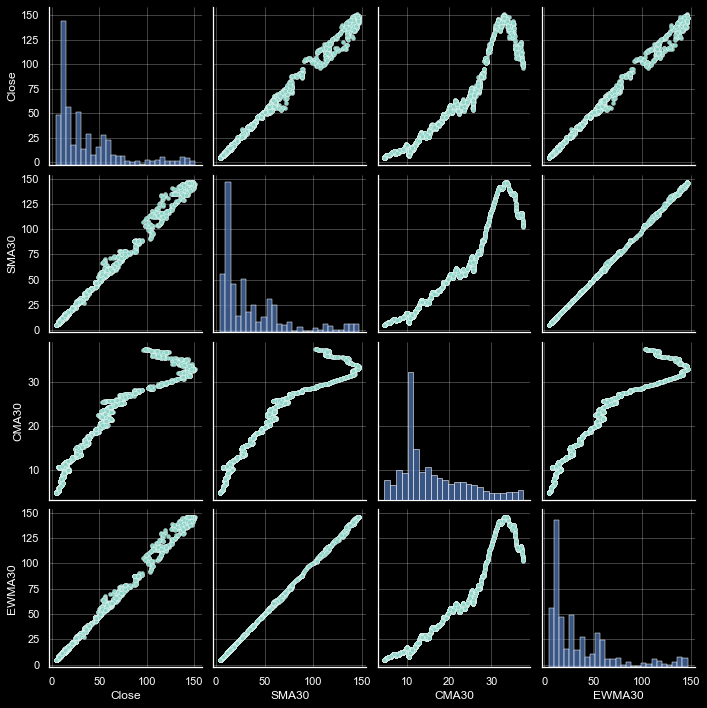

In [181]:
sns.pairplot(data=df_train)

Let's visualize the test part of df

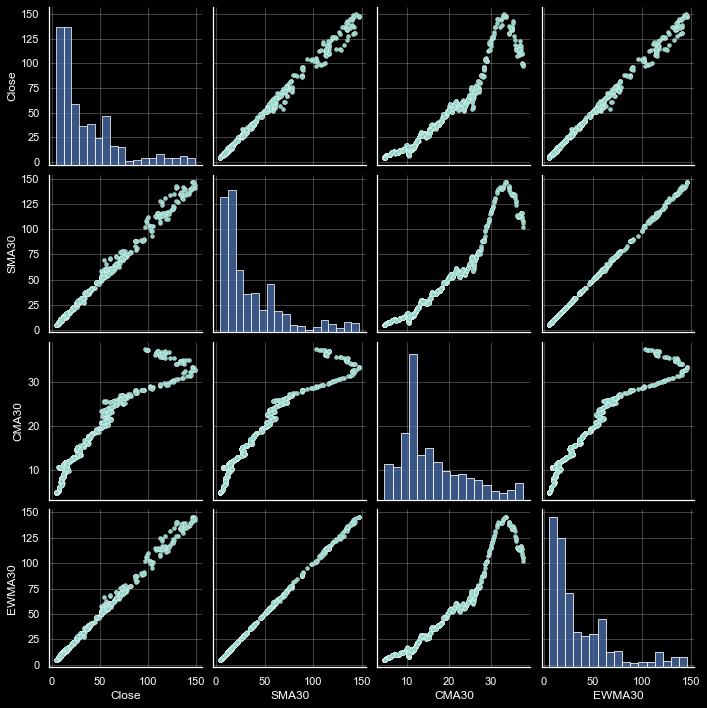

In [182]:
sns.pairplot(data=df_test)

We see that the train and test parts keep the same overall shapes as df. The difference is that they are less opaque which is reasonable since they are reduced in rows.

## 4.3 Model

In [183]:
model = LinearRegression(copy_X=True)

In [184]:
model.fit(X_train, y_train)

LinearRegression()

In [185]:
mini_summary = f'''
There were n = {model.n_features_in_} features, with names: {model.feature_names_in_} in the model: {model}.
The Slope calculated is {model.coef_.flatten()}.
The Intercept calculated is {model.intercept_}.
'''
print(mini_summary)


There were n = 3 features, with names: ['SMA30' 'CMA30' 'EWMA30'] in the model: LinearRegression().
The Slope calculated is [-2.24662282 -0.14573796  3.28431059].
The Intercept calculated is [1.25350031].



It seems that the most prominent of the moving averages is the EWMA assuming the only positive coefficient.

In [186]:
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred

,Close
Date,
2013-08-08,22.323693
2013-07-19,22.655485
2015-05-21,27.085748
2006-05-04,10.445924
2017-09-14,47.144336
...,...
2022-04-25,128.142924
2008-01-18,15.900047
2014-04-15,27.493716


<AxesSubplot:xlabel='Date', ylabel='Close'>

<AxesSubplot:xlabel='Date', ylabel='Close'>

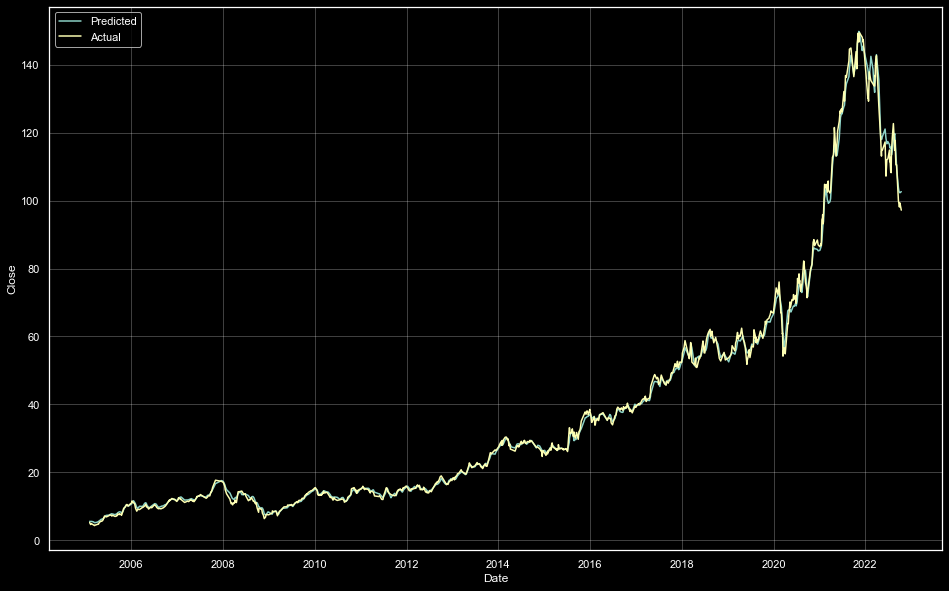

In [196]:
sns.lineplot(x=y_pred.index, y=y_pred['Close'], label='Predicted')
sns.lineplot(x=y_pred.index, y=y_test['Close'], label='Actual')

## 4.4 Model Valuation

In [187]:
mini_summary = f'''The Root Mean Square Error is: {np.sqrt(mean_squared_error(y_test,y_pred))}
The Correlation Coefficient $R^2$ is: {r2_score(y_test, y_pred)}
'''
print(mini_summary)

The Root Mean Square Error is: 1.6080881231467081
The Correlation Coefficient $R^2$ is: 0.9977203745138986



Although the RMSE is more than double than the other cases, the explanatory potential of the model has not changed.

<AxesSubplot:xlabel='Close', ylabel='Close'>

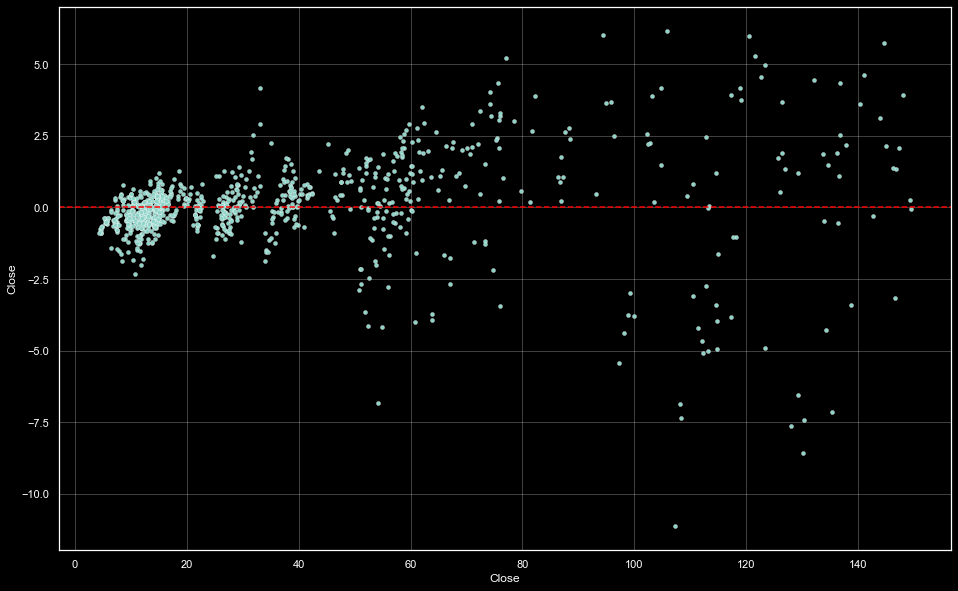

In [188]:
test_residuals = (y_test - y_pred)
sns.scatterplot(x=y_test['Close'], y=test_residuals['Close'])
plt.axhline(y=0, color='red', ls='--', label='Normality')

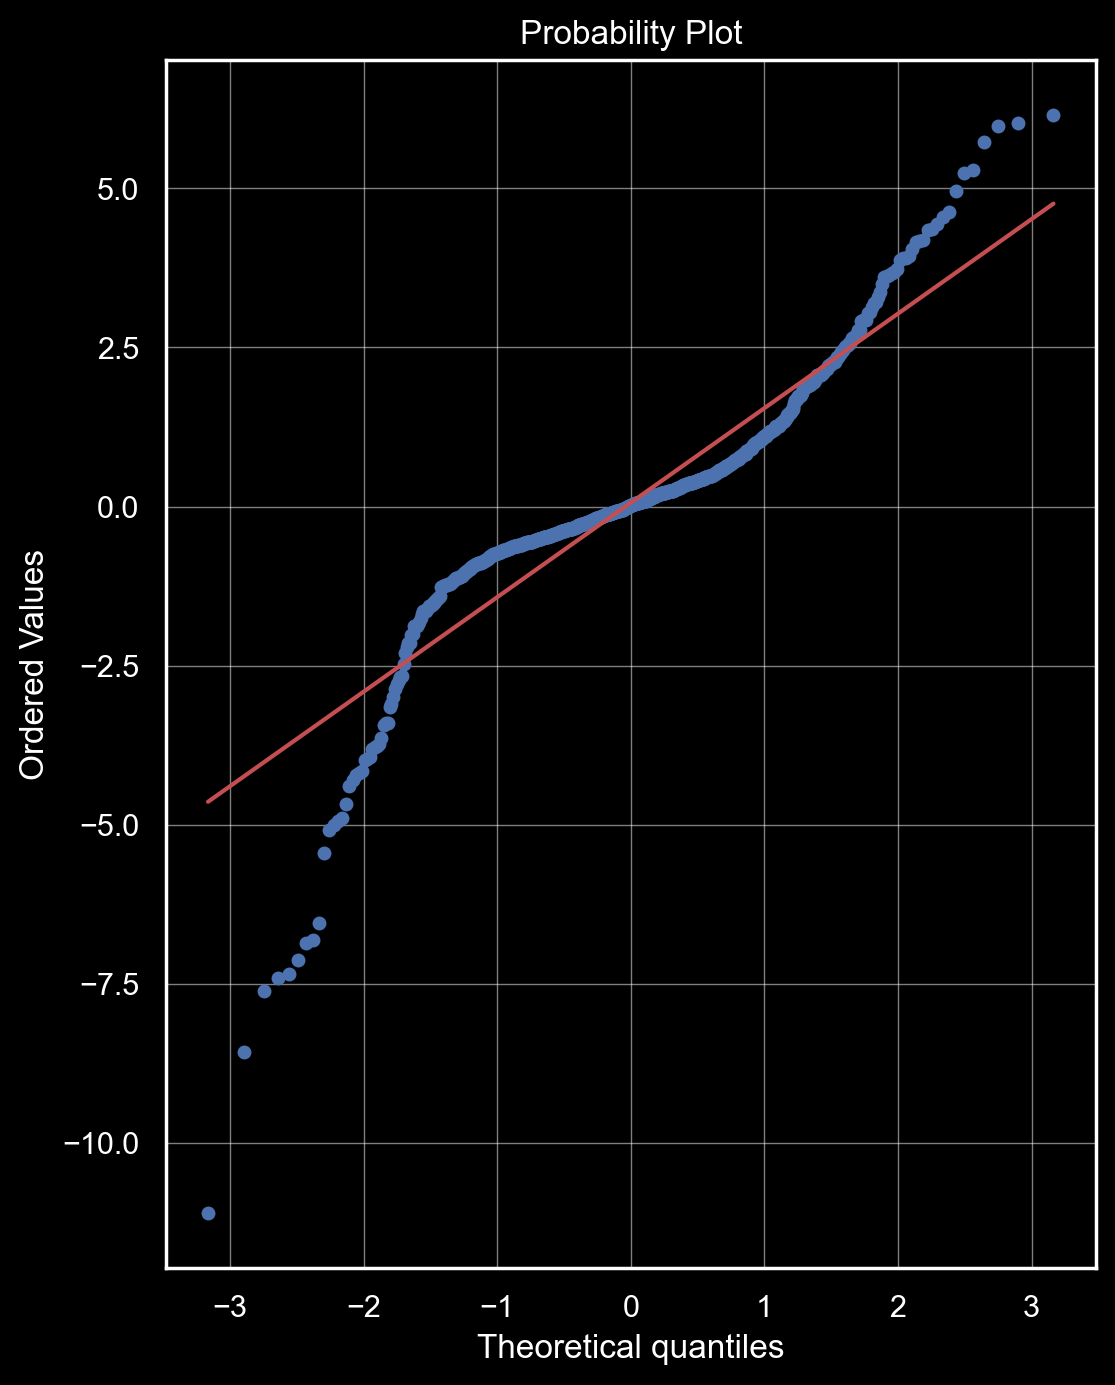

In [189]:
fig, ax = plt.subplots(figsize=(6,8),dpi=200)
_ = sc.stats.probplot(test_residuals['Close'], plot=ax)